In [2]:
!pip install wordcloud > /dev/null
!pip install msgpack > /dev/null
!pip install nltk > /dev/null
!pip install mxnet > /dev/null

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import boto3
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import re
import sagemaker
import scipy.sparse as sparse
import seaborn as sns
import time
import warnings

from scipy import interpolate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

%matplotlib inline
warnings.filterwarnings('ignore')

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

In [4]:
raw_data_filename = 'cleaned.csv'

df = pd.read_csv(raw_data_filename, parse_dates=[6])
df.head()

,id,tweet_url,created_at,parsed_created_at,user_screen_name,text,tweet_type,coordinates,hashtags,media,...,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_statuses_count,user_time_zone,user_urls,user_verified
0,1230472014130892800,https://twitter.com/digit96/status/12304720141...,Thu Feb 20 12:39:23 +0000 2020,2020-02-20T12:39:23+00:00,digit96,RT @W7VOA: #Singapore confirms first case with...,retweet,NaN,Singapore COVID19 coronavirus dengue,NaN,...,7856,1933,783,48,서울특별시 동대문구& 東京都 目黒区& 부산광역시 수영구,종이나무 Papertree,368281,NaN,NaN,False
1,1230472009605406720,https://twitter.com/coronahelps/status/1230472...,Thu Feb 20 12:39:22 +0000 2020,2020-02-20T12:39:22+00:00,coronahelps,#BREAKING: YouTube video about the CDC hiding ...,original,NaN,BREAKING coronavirus WuhanCoronavirus COVID19 ...,https://pbs.twimg.com/media/ERODw_dWAAMcsum.png,...,22,4,16,0,NaN,Coronahelps,35,NaN,NaN,False
2,1230472003301335041,https://twitter.com/tr1897gmailcom3/status/123...,Thu Feb 20 12:39:21 +0000 2020,2020-02-20T12:39:21+00:00,tr1897gmailcom3,"1. Wuhan 2. Qom, Iran 3. Daegu, South Korea 4...",original,NaN,coronavirus COVID19,NaN,...,3,8,166,0,"Weston, FL",Tom Ryan,47,NaN,NaN,False
3,1230472001439051776,https://twitter.com/meste48/status/12304720014...,Thu Feb 20 12:39:20 +0000 2020,2020-02-20T12:39:20+00:00,meste48,RT @BogochIsaac: Two elderly people succumbed ...,retweet,NaN,covid19,NaN,...,5279,1530,2724,64,NaN,maria eugenia este,39776,NaN,NaN,False
4,1230471998704422913,https://twitter.com/Starid23/status/1230471998...,Thu Feb 20 12:39:20 +0000 2020,2020-02-20T12:39:20+00:00,Starid23,RT @Finanzas_Time: #Coronavirus #COVID19 ☣️ C...,retweet,NaN,Coronavirus COVID19,NaN,...,64,7,98,0,"Lima, Peru",Cesar Gamarra,344,NaN,NaN,False


We have 20 columns:
id
tweet_url
created_at
parsed_created_at
user_screen_name
text
tweet_type
coordinates
hashtags
media
user_favourites_count
user_followers_count
user_friends_count
user_listed_count
user_location
user_name
user_statuses_count
user_time_zone
user_urls

In [5]:
def clean_tweet(text): 
   ext = "http" 
   tweet = text[:text.find(ext)].lower() 
   tweet = re.sub("[^\S]", " ", tweet) 
   tweet = re.sub("english translation ", "", tweet) 
   textOnly = re.sub("[^a-zA-Z0-9@# ]", "", tweet) 
   return(textOnly)

In [6]:
df.texts = df.text.apply(lambda x: clean_tweet)

In [7]:
keep_col = ['id', 'parsed_created_at', 'user_screen_name', 'text','user_followers_count','user_statuses_count', 'tweet_type', 'coordinates', 'hashtags', 'user_location', 'user_name', 'user_verified']

In [8]:
df[keep_col]

,id,parsed_created_at,user_screen_name,text,user_followers_count,user_statuses_count,tweet_type,coordinates,hashtags,user_location,user_name,user_verified
0,1230472014130892800,2020-02-20T12:39:23+00:00,digit96,RT @W7VOA: #Singapore confirms first case with...,1933,368281,retweet,NaN,Singapore COVID19 coronavirus dengue,서울특별시 동대문구& 東京都 目黒区& 부산광역시 수영구,종이나무 Papertree,False
1,1230472009605406720,2020-02-20T12:39:22+00:00,coronahelps,#BREAKING: YouTube video about the CDC hiding ...,4,35,original,NaN,BREAKING coronavirus WuhanCoronavirus COVID19 ...,NaN,Coronahelps,False
2,1230472003301335041,2020-02-20T12:39:21+00:00,tr1897gmailcom3,"1. Wuhan 2. Qom, Iran 3. Daegu, South Korea 4...",8,47,original,NaN,coronavirus COVID19,"Weston, FL",Tom Ryan,False
3,1230472001439051776,2020-02-20T12:39:20+00:00,meste48,RT @BogochIsaac: Two elderly people succumbed ...,1530,39776,retweet,NaN,covid19,NaN,maria eugenia este,False
4,1230471998704422913,2020-02-20T12:39:20+00:00,Starid23,RT @Finanzas_Time: #Coronavirus #COVID19 ☣️ C...,7,344,retweet,NaN,Coronavirus COVID19,"Lima, Peru",Cesar Gamarra,False
5,1230471997559394306,2020-02-20T12:39:19+00:00,AmitTrds,RT @bsindia: Icra downgrades Indian pharma ind...,249,4926,retweet,NaN,China,India,Amit Jain,False
6,1230471992618475520,2020-02-20T12:39:18+00:00,no10chico,RT @DarrenPlymouth: Off to the treatment camp ...,1192,12953,retweet,NaN,coronavirus,redditch,redditchgardener,False
7,1230471982296100864,2020-02-20T12:39:16+00:00,Miruku43780816,RT @HongKongFP: Xi Jinping’s coronavirus power...,830,5326,retweet,NaN,China coronavirus,Hong Kong,Love freedom democracy,False
8,1230471979519631360,2020-02-20T12:39:15+00:00,Chineinfocom,#coronavirus #Covid19 #épidémie #hôpital #XiAn...,753,2869,original,NaN,coronavirus Covid19 épidémie hôpital XiAn Shaa...,NaN,Chine-info.com,False
9,1230471977460273152,2020-02-20T12:39:15+00:00,mpimnapas,RT @kingjames_x: Scientist: Antimalarial drug ...,65,53220,retweet,NaN,COVID19,United Kingdom,mm,False


In [9]:
df.parsed_created_at = pd.to_datetime(df.parsed_created_at)
perhr = df.set_index(df.parsed_created_at).resample('D').count()

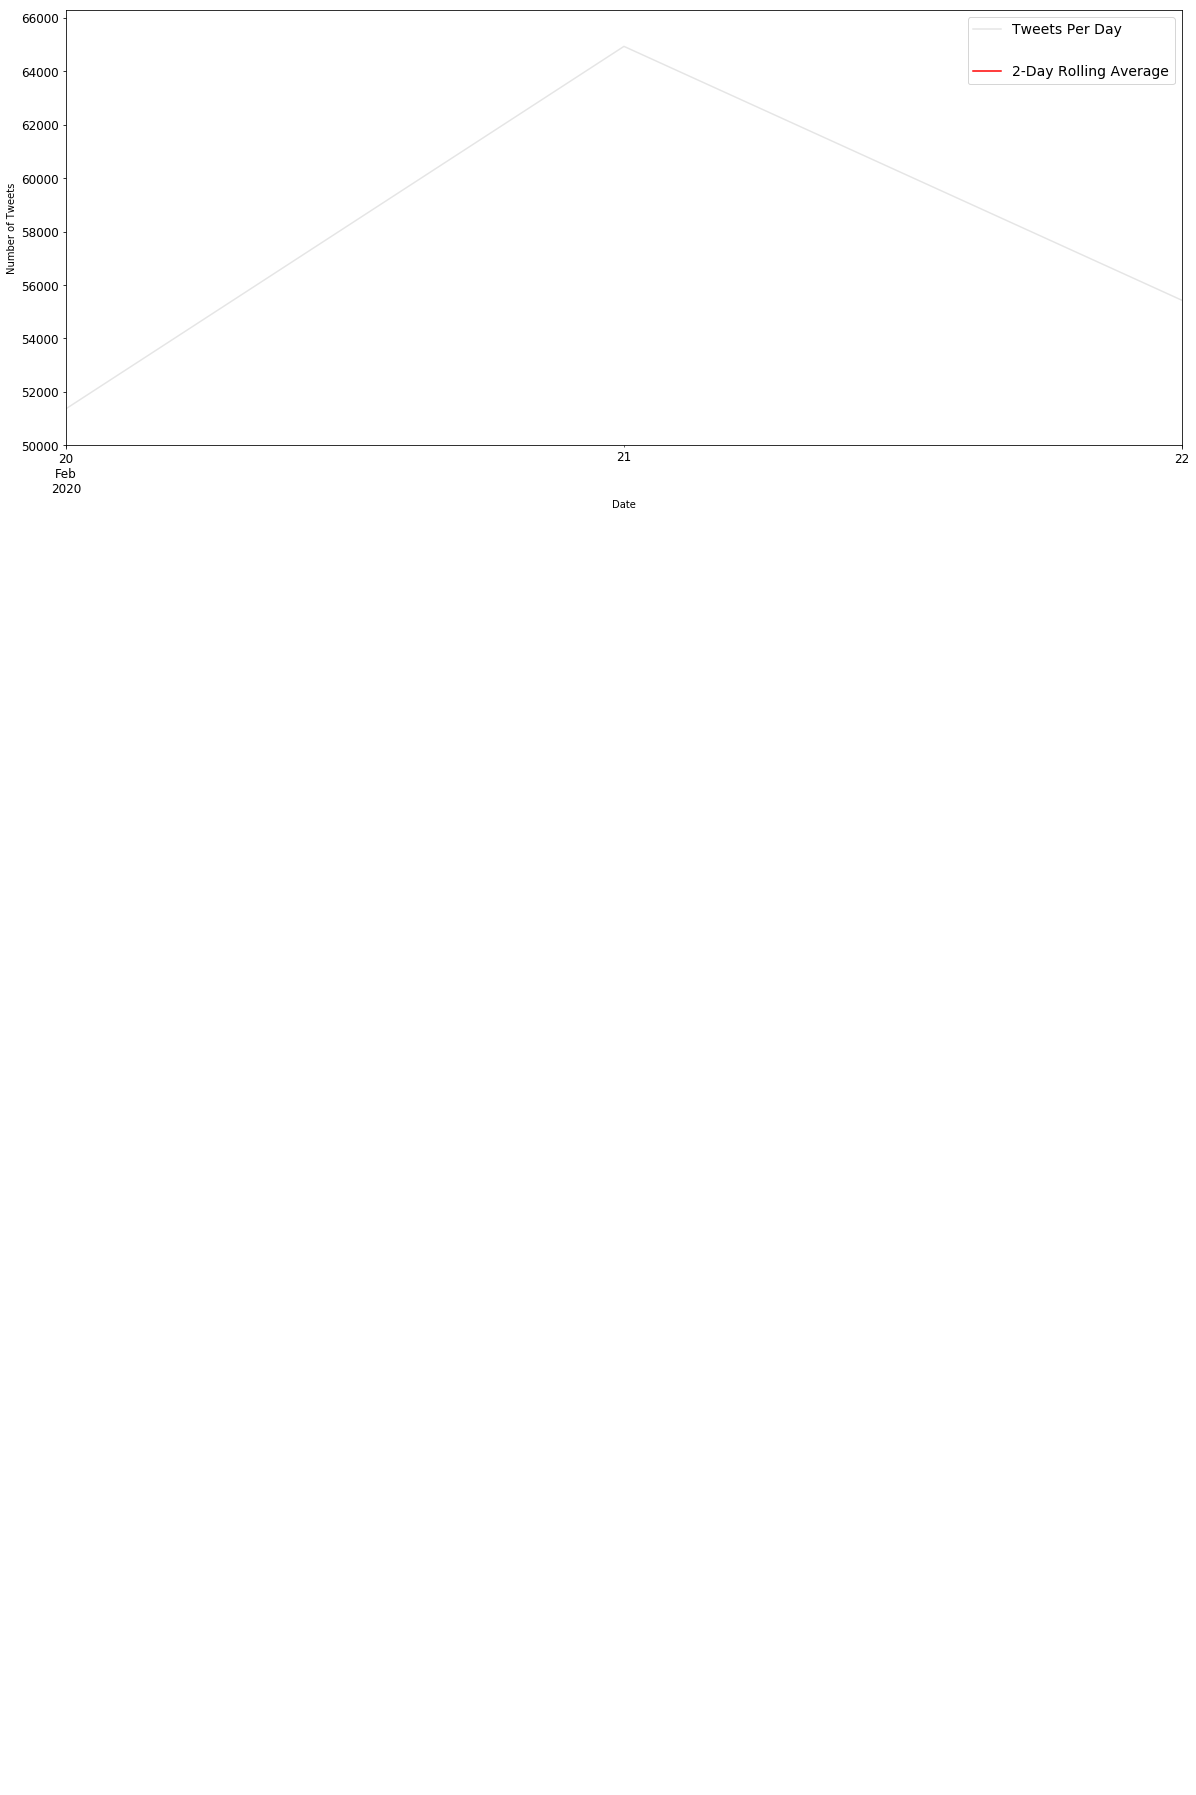

In [10]:
fig, ax = plt.subplots(figsize = (20,8))
perhr['2020-02-20':].user_statuses_count.interpolate(method='linear').plot(ax = ax, color="black", fontsize=12, alpha=0.1)
pd.DataFrame.rolling(perhr, window=7).mean().text['2020-02-20':].plot(color ='r') 
China ='2020-02-20'
AMERICA = '2020-02-20' 
ax.annotate('COVID IN CHINA',xy=(China, 200),xytext=('2020-02-20', 310), 
           arrowprops=dict(facecolor='white', shrink=0.05), size=15) 
ax.annotate('COVID IN USA',xy=(AMERICA, 200),xytext=('2020-02-20', 310), 
           arrowprops=dict(facecolor='white', shrink=0.05),size=15) 
ax.margins(None,0.1)
ax.legend(['Tweets Per Day','2-Day Rolling Average'], loc = 'upper right', 
          numpoints = 1, labelspacing = 2.0, fontsize = 14)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
plt.show()

KEYWORD ANALYSIS

In [11]:
emoticons_str = r"""
   (?:
       [:=;] # Eyes
       [oO\-]? # Nose (optional)
       [D\)\]\(\]/\\OpP] # Mouth
   )""" 
 
regex_str = [ 
   emoticons_str, 
   r'<[^>]+>', # HTML tags 
   r'(?:@[\w_]+)', # @-mentions 
   r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags 
   r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs  
   r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers 
   r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and ' 
   r'(?:[\w_]+)', # other words 
   r'(?:\S)' # anything else
]
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE) 
 
def tokenize(s): 
   return tokens_re.findall(s)
Tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenize, ngram_range=(1,
2), stop_words='english', 
                                  token_pattern='\\b[a-z][a-z]+\\b', max_df=.5)
tfidf_tweets = Tfidf_vectorizer.fit_transform(df.text.values.astype('U'))

In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { 
   return false;
}

<IPython.core.display.Javascript object>

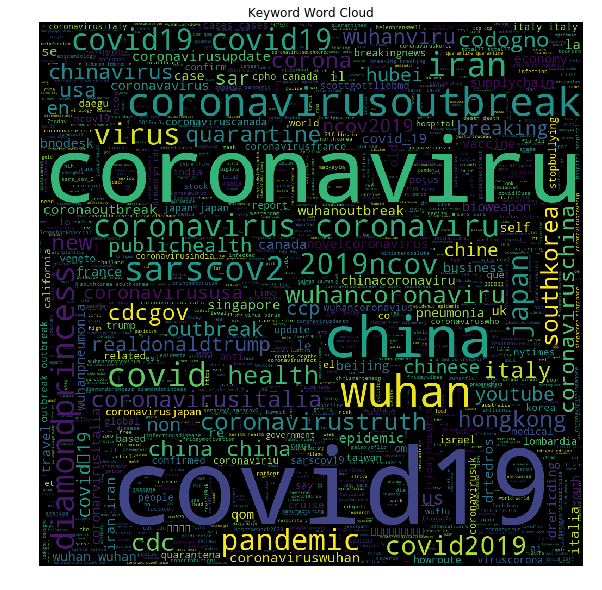

In [13]:
terms = Tfidf_vectorizer.get_feature_names()
wc = WordCloud(height=1000, width=1000, max_words=1000).generate("".join(terms))
plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.title("Keyword Word Cloud")
plt.show()

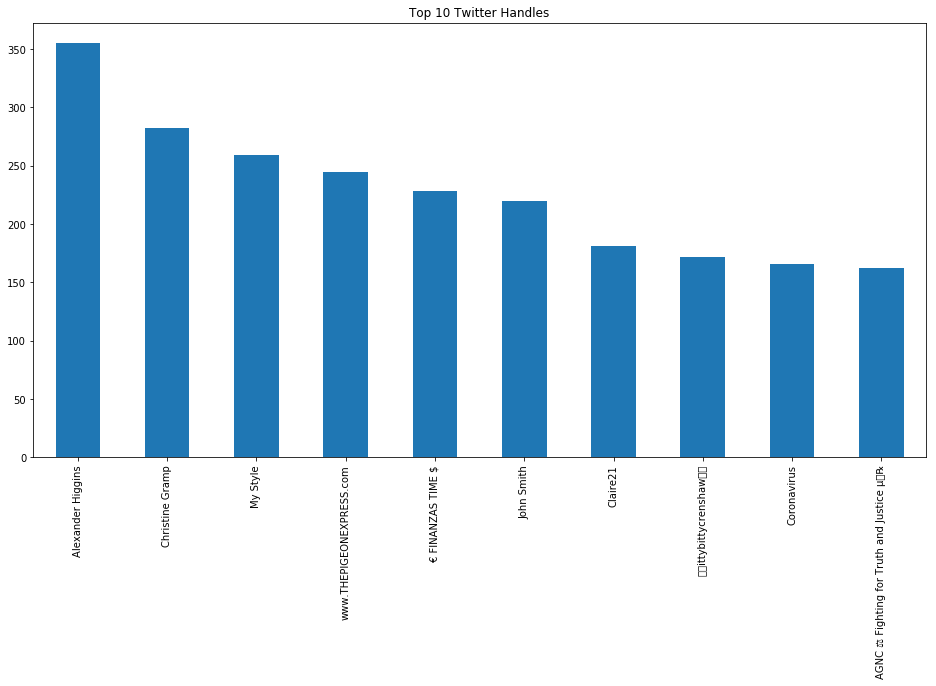

In [14]:
top_users = df.user_name.value_counts().sort_values(ascending=False)
top_users.head(10).plot.bar(title="Top 10 Twitter Handles", figsize=(16,8))

In [15]:
pd.options.mode.chained_assignment = None  
 
mentions = df.loc[df.text.str.contains('@', na=False)]
mentions['Tagged User'] = mentions.text.apply(lambda x: re.findall(r'@([A-Za-z0-9_]+)',
str(x)))
users = mentions.user_name.unique()
mentions['Tagged User Cnt'] = mentions['Tagged User'].apply(lambda x: list(set(x).intersection(users)) )
mentions['Cnt length'] = mentions['Tagged User Cnt'].apply(lambda x: len(x))  
 
for i in range(len(mentions.text)):  
   row = mentions.iloc[i,:]  
     
     
   for j in range(len(row['Tagged User'])):  
       tmp = pd.DataFrame({'User':[row['user_name']],  
                           'Mentions':[row['Tagged User'][j]],  
                           'Time': [row['parsed_created_at']],  
                           'User num status':[row['user_statuses_count']],  
                           'Followers':[row['user_followers_count']],  
                           'Weight': [1]})  
       if i==0 and j==0:  
           mention_net = tmp  
       else:  
           mention_net = mention_net.append(tmp, ignore_index=True)  
             
mention_net = mention_net[mention_net['User']!=mention_net['Mentions']].reset_index(drop=True)
mention_net.head(5)

,User,Mentions,Time,User num status,Followers,Weight
0,종이나무 Papertree,W7VOA,2020-02-20 12:39:23+00:00,368281,1933,1
1,maria eugenia este,BogochIsaac,2020-02-20 12:39:20+00:00,39776,1530,1
2,Cesar Gamarra,Finanzas_Time,2020-02-20 12:39:20+00:00,344,7,1
3,Amit Jain,bsindia,2020-02-20 12:39:19+00:00,4926,249,1
4,redditchgardener,DarrenPlymouth,2020-02-20 12:39:18+00:00,12953,1192,1


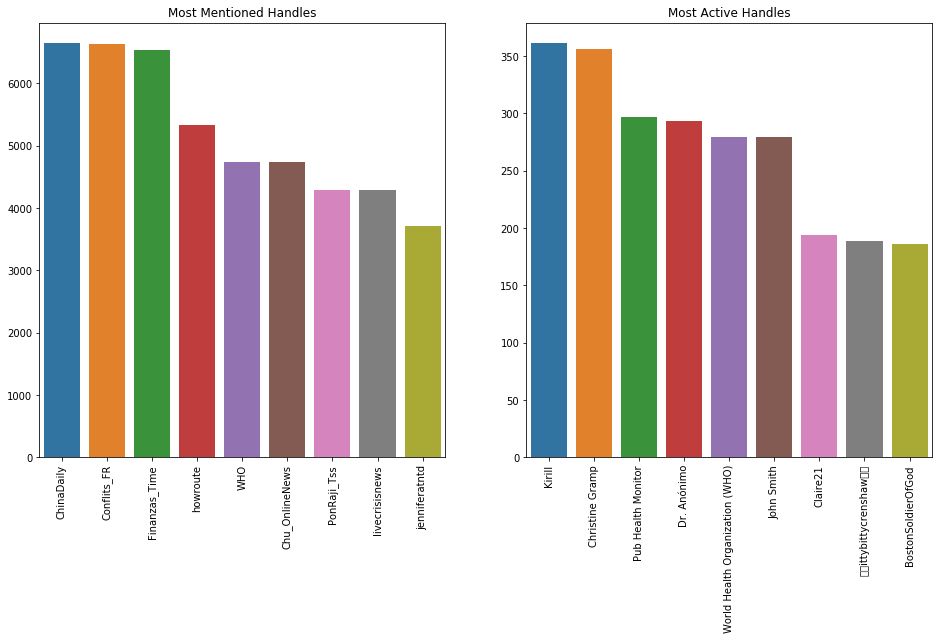

In [16]:
most_mentions = mention_net.Mentions.value_counts().sort_values(ascending=False)
most_active = mention_net.User.value_counts().sort_values(ascending=False)  
 
plt.figure(figsize=(16,8))
ax1 = plt.subplot(121)
ax1 = sns.barplot(most_mentions[0:9].index, most_mentions[0:9].values)
ax1 = plt.title("Most Mentioned Handles")
ax1 =plt.xticks(rotation=90)
ax2 = plt.subplot(122)
ax2 = sns.barplot(most_active[0:9].index, most_active[0:9].values)
ax2 = plt.title("Most Active Handles")
ax2 =plt.xticks(rotation=90)
plt.show()

In [17]:
network = mention_net.iloc[:,[0,1,5]] #Use the mentions, user, and weight columns to bulid the network
print(network)
network = network.groupby(by=['Mentions','User'],as_index='False')['Weight'].sum().reset_index(name='Weight')
network= pd.DataFrame(network).sort_values(by='Weight',ascending=False).reset_index(drop=True)
network = network[network['Weight']>20]  
 
print('Most frequent user/mention pairs:')
network.head(10)

                              User         Mentions  Weight
0                   종이나무 Papertree            W7VOA       1
1               maria eugenia este      BogochIsaac       1
2                    Cesar Gamarra    Finanzas_Time       1
3                        Amit Jain          bsindia       1
4                 redditchgardener   DarrenPlymouth       1
5           Love freedom democracy       HongKongFP       1
6                               mm      kingjames_x       1
7                      tammy gomes      YourMorning       1
8                               金马         SYC99999       1
9                 Michelle Barnett   JenniferHYChan       1
10                    ⏳carol muse⏳            W7VOA       1
11                           Jenny  xinjiangchannel       1
12                  Guillermo Chan           erveza       1
13                       Bart Rule         howroute       1
14                               🍑    jenniferatntd       1
15                    Agnes Mizere      

,Mentions,User,Weight
0,Finanzas_Time,Anto lo,138
1,Finanzas_Time,Dr. Anónimo,115
2,Finanzas_Time,T 1,108
3,DrTedros,World Health Organization (WHO),102
4,chrismartenson,Memento Mori,87
5,Finanzas_Time,TAURUS,84
6,Conflits_FR,Brest Newzh ✊🇫🇷🇪🇺🌍,77
7,Conflits_FR,Genevieve Grimaud,77
8,Conflits_FR,Johan Weylland 🇫🇷 🇺🇸,74
9,Finanzas_Time,Ultraderecha 🇺🇸🇧🇷,73


(-1.108365113333715,
 1.1353563891931373,
 -1.105456345362919,
 1.1054563490233287)

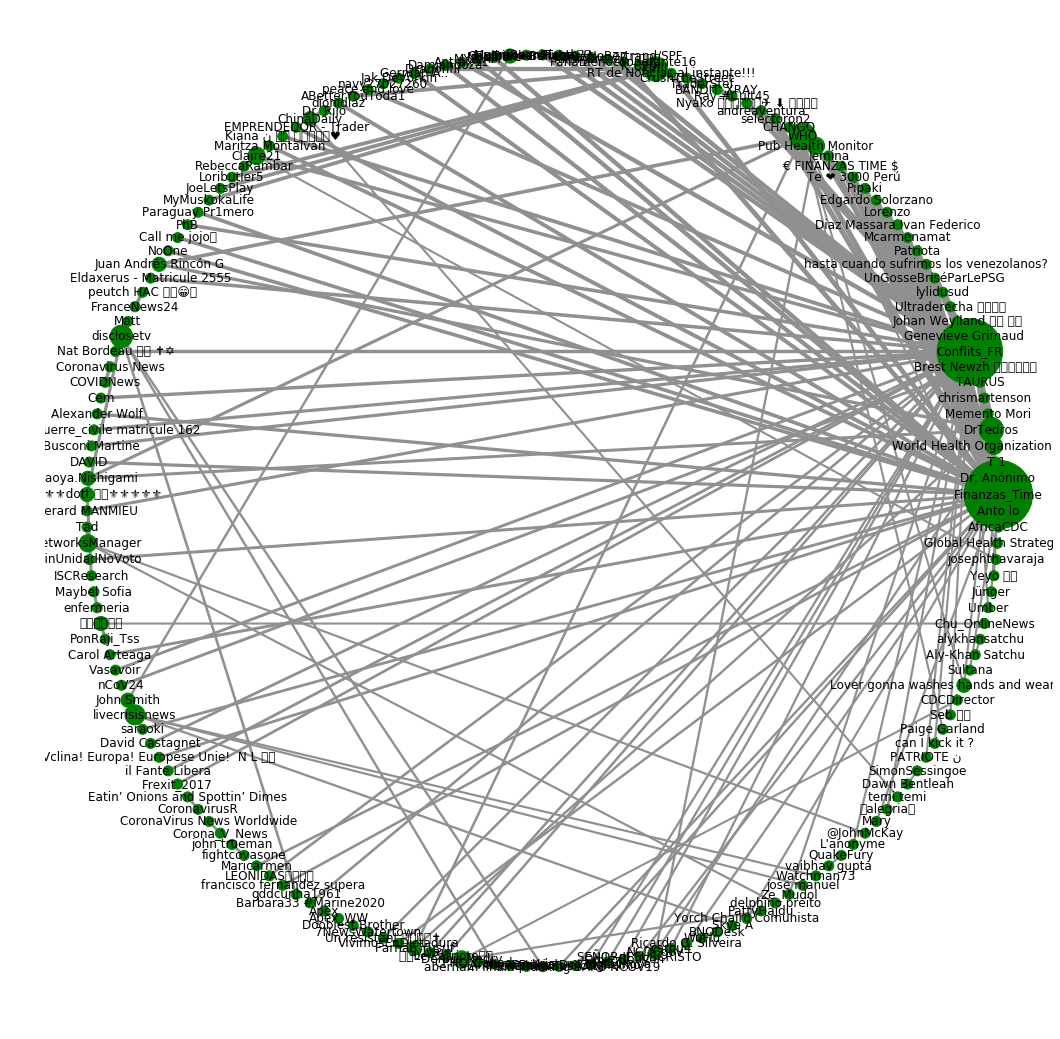

In [25]:
G = nx.Graph()
for i in range(len(network['User'])):  
   G.add_edge(network['User'][i],network['Mentions'][i],weight=network['Weight'][i])  
     
plt.figure(figsize=(14,14))
d=list(nx.degree(G))
weights = [G.edges[u, v]['weight']/10 for u, v in G.edges()]
size = [d[:][v][1]*100 for v in range(len(d))]  
 
nx.draw_circular(G,node_color='g', node_size=size, edge_color='#909090', with_labels=True, width=weights)
plt.axis('equal')

In [49]:
from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, ColumnDataSource, LabelSet
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4 
plot = Plot(plot_width=5000, plot_height=1000, x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
plot.title.text = "Graph Interaction Demonstration" 
plot.add_tools(HoverTool(tooltips=None), TapTool(), BoxSelectTool()) 
graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0,0)) 
graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1]) 
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5) 
graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes() 
pos =nx.circular_layout(G)
x, y = zip(*pos.values())
node_labels = list(G.nodes)
source = ColumnDataSource({'x': x, 'y': y, 
                           'label': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='label', source=source,  x_offset=5, y_offset=5) 
plot.renderers.append(labels)
plot.renderers.append(graph_renderer) 
output_notebook()
show(plot)

Loading BokehJS ...

In [30]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

token_pattern = re.compile(r"(?u)\b\w\w+\b")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t)]

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [31]:
vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english',
                             tokenizer=LemmaTokenizer(), max_features=vocab_size, max_df=0.95, min_df=2)
vectors = vectorizer.fit_transform(df.text.values.astype('U'))
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

# Random Shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

np.save('vocab', vocab_list)

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...
vocab size: 2000
Done. Time elapsed: 86.09s


In [41]:
vectors = sparse.csr_matrix(vectors, dtype=np.float32)

print(type(vectors), vectors.dtype)

n_train = int(0.8 * vectors.shape[0])

# Split Train/Test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# Split test set into validation set (val_vectors) and test set (test_vectors).
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

<class 'scipy.sparse.csr.csr_matrix'> float32
(143918, 2000) (17990, 2000) (17990, 2000)


In [32]:
bucket = sagemaker_session.default_bucket()
prefix = 'twitter_analysis'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Training set location s3://sagemaker-us-east-1-714697274720/twitter_analysis/train
Validation set location s3://sagemaker-us-east-1-714697274720/twitter_analysis/val
Trained model will be saved at s3://sagemaker-us-east-1-714697274720/twitter_analysis/output


In [33]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):
        # Calculate Start/End Indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to Record Protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to S3
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))
        

In [34]:
from sagemaker.amazon.amazon_estimator import get_image_uri

region_name = boto3.Session().region_name
container = get_image_uri(region_name, 'ntm')

print('Using SageMaker NTM container: {} ({})'.format(container, region_name))

Using SageMaker NTM container: 382416733822.dkr.ecr.us-east-1.amazonaws.com/ntm:1 (us-east-1)


In [55]:
from sagemaker.session import s3_input
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=2, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sagemaker_session)

num_topics = 10
ntm.set_hyperparameters(num_topics=num_topics, feature_dim=vocab_size, mini_batch_size=128, 
                        epochs=100, num_patience_epochs=5, tolerance=0.001)

s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key')

In [56]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return true;
}

<IPython.core.display.Javascript object>

In [57]:
ntm.fit({'train': s3_train, 'test': s3_val_data})

2020-04-25 20:21:54 Starting - Starting the training job...
2020-04-25 20:21:55 Starting - Launching requested ML instances......
2020-04-25 20:23:01 Starting - Preparing the instances for training......
2020-04-25 20:24:16 Downloading - Downloading input data...
2020-04-25 20:24:54 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[04/25/2020 20:24:57 INFO 139911781308224] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_object

Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[04/25/2020 20:24:57 INFO 139857738135360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_data_format': u'record', u'sub_sample': u'1.0', u'epochs': u'50', u'weight_decay': u'0.0', u'_num_kv_servers': u'auto', u'encoder_layers_activation': u'sigmoid', u'mini_batch_size': u'256', u'tolerance': u'0.001', u'batch_norm': u'false'}
[04/25/2020 20:24:57 INFO 139857738135360]

[2020-04-25 20:25:15.104] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 2, "duration": 15125, "num_examples": 563, "num_bytes": 6498004}
[04/25/2020 20:25:15 INFO 139857738135360] # Finished training epoch 1 on 71956 examples from 563 batches, each of size 128.
[04/25/2020 20:25:15 INFO 139857738135360] Metrics for Training:
[04/25/2020 20:25:15 INFO 139857738135360] Loss (name: value) total: 5.96354867129
[04/25/2020 20:25:15 INFO 139857738135360] Loss (name: value) kld: 0.0656683124886
[04/25/2020 20:25:15 INFO 139857738135360] Loss (name: value) recons: 5.89788036596
[04/25/2020 20:25:15 INFO 139857738135360] Loss (name: value) logppx: 5.96354867129
[04/25/2020 20:25:15 INFO 139857738135360] #quality_metric: host=algo-1, epoch=1, train total_loss <loss>=5.96354867129
[04/25/2020 20:25:15 INFO 139857738135360] Timing: train: 15.13s, val: 0.00s, epoch: 15.13s
[04/25/2020 20:25:15 INFO 139857738135360] #progress_metric: host=algo-1, completed 1 % 

[2020-04-25 20:25:45.059] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 8, "duration": 14771, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:25:45 INFO 139911781308224] # Finished training epoch 3 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:25:45 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:25:45 INFO 139911781308224] Loss (name: value) total: 5.53228503709
[04/25/2020 20:25:45 INFO 139911781308224] Loss (name: value) kld: 0.224875223719
[04/25/2020 20:25:45 INFO 139911781308224] Loss (name: value) recons: 5.30740981945
[04/25/2020 20:25:45 INFO 139911781308224] Loss (name: value) logppx: 5.53228503709
[04/25/2020 20:25:45 INFO 139911781308224] #quality_metric: host=algo-2, epoch=3, train total_loss <loss>=5.53228503709
[04/25/2020 20:25:45 INFO 139911781308224] Timing: train: 14.77s, val: 0.00s, epoch: 14.78s
[04/25/2020 20:25:45 INFO 139911781308224] #progress_metric: host=algo-2, completed 3 % o

[2020-04-25 20:26:15.027] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 14, "duration": 14872, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:26:15 INFO 139911781308224] # Finished training epoch 5 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:26:15 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:26:15 INFO 139911781308224] Loss (name: value) total: 5.2440358989
[04/25/2020 20:26:15 INFO 139911781308224] Loss (name: value) kld: 0.362095688339
[04/25/2020 20:26:15 INFO 139911781308224] Loss (name: value) recons: 4.88194022297
[04/25/2020 20:26:15 INFO 139911781308224] Loss (name: value) logppx: 5.2440358989
[04/25/2020 20:26:15 INFO 139911781308224] #quality_metric: host=algo-2, epoch=5, train total_loss <loss>=5.2440358989
[04/25/2020 20:26:15 INFO 139911781308224] Timing: train: 14.87s, val: 0.00s, epoch: 14.88s
[04/25/2020 20:26:15 INFO 139911781308224] #progress_metric: host=algo-2, completed 5 % of 

[2020-04-25 20:26:44.744] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 20, "duration": 14891, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:26:44 INFO 139911781308224] # Finished training epoch 7 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:26:44 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:26:44 INFO 139911781308224] Loss (name: value) total: 5.15650600523
[04/25/2020 20:26:44 INFO 139911781308224] Loss (name: value) kld: 0.412390716533
[04/25/2020 20:26:44 INFO 139911781308224] Loss (name: value) recons: 4.7441152944
[04/25/2020 20:26:44 INFO 139911781308224] Loss (name: value) logppx: 5.15650600523
[04/25/2020 20:26:44 INFO 139911781308224] #quality_metric: host=algo-2, epoch=7, train total_loss <loss>=5.15650600523
[04/25/2020 20:26:44 INFO 139911781308224] patience losses:[5.731477815558601, 5.532285037091528, 5.364998473155562, 5.244035898898042, 5.189045002998298] min patience loss:5.189045

[2020-04-25 20:27:14.408] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 26, "duration": 14764, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:27:14 INFO 139911781308224] # Finished training epoch 9 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:27:14 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:27:14 INFO 139911781308224] Loss (name: value) total: 5.07343712835
[04/25/2020 20:27:14 INFO 139911781308224] Loss (name: value) kld: 0.474425610519
[04/25/2020 20:27:14 INFO 139911781308224] Loss (name: value) recons: 4.59901151479
[04/25/2020 20:27:14 INFO 139911781308224] Loss (name: value) logppx: 5.07343712835
[04/25/2020 20:27:14 INFO 139911781308224] #quality_metric: host=algo-2, epoch=9, train total_loss <loss>=5.07343712835
[04/25/2020 20:27:14 INFO 139911781308224] patience losses:[5.364998473155562, 5.244035898898042, 5.189045002998298, 5.156506005231271, 5.120341030996604] min patience loss:5.12034

[2020-04-25 20:27:44.054] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 32, "duration": 14795, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:27:44 INFO 139911781308224] # Finished training epoch 11 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:27:44 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:27:44 INFO 139911781308224] Loss (name: value) total: 4.9975442808
[04/25/2020 20:27:44 INFO 139911781308224] Loss (name: value) kld: 0.526557438658
[04/25/2020 20:27:44 INFO 139911781308224] Loss (name: value) recons: 4.47098683718
[04/25/2020 20:27:44 INFO 139911781308224] Loss (name: value) logppx: 4.9975442808
[04/25/2020 20:27:44 INFO 139911781308224] #quality_metric: host=algo-2, epoch=11, train total_loss <loss>=4.9975442808
[04/25/2020 20:27:44 INFO 139911781308224] patience losses:[5.189045002998298, 5.156506005231271, 5.120341030996604, 5.073437128354982, 5.032838052585324] min patience loss:5.032838

[2020-04-25 20:28:13.792] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 38, "duration": 14808, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:28:13 INFO 139911781308224] # Finished training epoch 13 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:28:13 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:28:13 INFO 139911781308224] Loss (name: value) total: 4.94078452549
[04/25/2020 20:28:13 INFO 139911781308224] Loss (name: value) kld: 0.570980445689
[04/25/2020 20:28:13 INFO 139911781308224] Loss (name: value) recons: 4.36980407488
[04/25/2020 20:28:13 INFO 139911781308224] Loss (name: value) logppx: 4.94078452549
[04/25/2020 20:28:13 INFO 139911781308224] #quality_metric: host=algo-2, epoch=13, train total_loss <loss>=4.94078452549
[04/25/2020 20:28:13 INFO 139911781308224] patience losses:[5.120341030996604, 5.073437128354982, 5.032838052585324, 4.997544280800896, 4.9663142622258265] min patience loss:4.96

[2020-04-25 20:28:43.376] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 44, "duration": 14751, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:28:43 INFO 139911781308224] # Finished training epoch 15 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:28:43 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:28:43 INFO 139911781308224] Loss (name: value) total: 4.91425522013
[04/25/2020 20:28:43 INFO 139911781308224] Loss (name: value) kld: 0.593719513309
[04/25/2020 20:28:43 INFO 139911781308224] Loss (name: value) recons: 4.32053569377
[04/25/2020 20:28:43 INFO 139911781308224] Loss (name: value) logppx: 4.91425522013
[04/25/2020 20:28:43 INFO 139911781308224] #quality_metric: host=algo-2, epoch=15, train total_loss <loss>=4.91425522013
[04/25/2020 20:28:43 INFO 139911781308224] patience losses:[5.032838052585324, 4.997544280800896, 4.9663142622258265, 4.940784525490146, 4.924923123517214] min patience loss:4.92

[2020-04-25 20:29:12.849] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 50, "duration": 14672, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:29:12 INFO 139911781308224] # Finished training epoch 17 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:29:12 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:29:12 INFO 139911781308224] Loss (name: value) total: 4.89328011166
[04/25/2020 20:29:12 INFO 139911781308224] Loss (name: value) kld: 0.610983353499
[04/25/2020 20:29:12 INFO 139911781308224] Loss (name: value) recons: 4.2822967557
[04/25/2020 20:29:12 INFO 139911781308224] Loss (name: value) logppx: 4.89328011166
[04/25/2020 20:29:12 INFO 139911781308224] #quality_metric: host=algo-2, epoch=17, train total_loss <loss>=4.89328011166
[04/25/2020 20:29:12 INFO 139911781308224] patience losses:[4.9663142622258265, 4.940784525490146, 4.924923123517214, 4.914255220132018, 4.901728148782232] min patience loss:4.901

[2020-04-25 20:29:42.349] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 56, "duration": 14829, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:29:42 INFO 139911781308224] # Finished training epoch 19 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:29:42 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:29:42 INFO 139911781308224] Loss (name: value) total: 4.88131130779
[04/25/2020 20:29:42 INFO 139911781308224] Loss (name: value) kld: 0.624334169866
[04/25/2020 20:29:42 INFO 139911781308224] Loss (name: value) recons: 4.25697713826
[04/25/2020 20:29:42 INFO 139911781308224] Loss (name: value) logppx: 4.88131130779
[04/25/2020 20:29:42 INFO 139911781308224] #quality_metric: host=algo-2, epoch=19, train total_loss <loss>=4.88131130779
[04/25/2020 20:29:42 INFO 139911781308224] patience losses:[4.924923123517214, 4.914255220132018, 4.901728148782232, 4.893280111663507, 4.8891542423681935] min patience loss:4.88

[2020-04-25 20:30:12.026] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 62, "duration": 14985, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:30:12 INFO 139911781308224] # Finished training epoch 21 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:30:12 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:30:12 INFO 139911781308224] Loss (name: value) total: 4.87259257327
[04/25/2020 20:30:12 INFO 139911781308224] Loss (name: value) kld: 0.637732458951
[04/25/2020 20:30:12 INFO 139911781308224] Loss (name: value) recons: 4.23486010463
[04/25/2020 20:30:12 INFO 139911781308224] Loss (name: value) logppx: 4.87259257327
[04/25/2020 20:30:12 INFO 139911781308224] #quality_metric: host=algo-2, epoch=21, train total_loss <loss>=4.87259257327
[04/25/2020 20:30:12 INFO 139911781308224] patience losses:[4.901728148782232, 4.893280111663507, 4.8891542423681935, 4.881311307791918, 4.876026507381012] min patience loss:4.87

[2020-04-25 20:30:41.845] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 68, "duration": 14990, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:30:41 INFO 139911781308224] # Finished training epoch 23 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:30:41 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:30:41 INFO 139911781308224] Loss (name: value) total: 4.86145334811
[04/25/2020 20:30:41 INFO 139911781308224] Loss (name: value) kld: 0.651913930584
[04/25/2020 20:30:41 INFO 139911781308224] Loss (name: value) recons: 4.20953942849
[04/25/2020 20:30:41 INFO 139911781308224] Loss (name: value) logppx: 4.86145334811
[04/25/2020 20:30:41 INFO 139911781308224] #quality_metric: host=algo-2, epoch=23, train total_loss <loss>=4.86145334811
[04/25/2020 20:30:41 INFO 139911781308224] patience losses:[4.8891542423681935, 4.881311307791918, 4.876026507381012, 4.872592573267529, 4.866260772064778] min patience loss:4.86

[2020-04-25 20:31:11.521] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 74, "duration": 14877, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:31:11 INFO 139911781308224] # Finished training epoch 25 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:31:11 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:31:11 INFO 139911781308224] Loss (name: value) total: 4.85011856531
[04/25/2020 20:31:11 INFO 139911781308224] Loss (name: value) kld: 0.661559491688
[04/25/2020 20:31:11 INFO 139911781308224] Loss (name: value) recons: 4.18855907618
[04/25/2020 20:31:11 INFO 139911781308224] Loss (name: value) logppx: 4.85011856531
[04/25/2020 20:31:11 INFO 139911781308224] #quality_metric: host=algo-2, epoch=25, train total_loss <loss>=4.85011856531
[04/25/2020 20:31:11 INFO 139911781308224] patience losses:[4.876026507381012, 4.872592573267529, 4.866260772064778, 4.86145334811236, 4.856283369326888] min patience loss:4.8562

[2020-04-25 20:31:41.405] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 80, "duration": 15013, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:31:41 INFO 139911781308224] # Finished training epoch 27 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:31:41 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:31:41 INFO 139911781308224] Loss (name: value) total: 4.84601239921
[04/25/2020 20:31:41 INFO 139911781308224] Loss (name: value) kld: 0.671592678895
[04/25/2020 20:31:41 INFO 139911781308224] Loss (name: value) recons: 4.17441972736
[04/25/2020 20:31:41 INFO 139911781308224] Loss (name: value) logppx: 4.84601239921
[04/25/2020 20:31:41 INFO 139911781308224] #quality_metric: host=algo-2, epoch=27, train total_loss <loss>=4.84601239921
[04/25/2020 20:31:41 INFO 139911781308224] patience losses:[4.866260772064778, 4.86145334811236, 4.856283369326888, 4.8501185653053, 4.849118924056234] min patience loss:4.849118

[2020-04-25 20:32:11.183] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 86, "duration": 14983, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:32:11 INFO 139911781308224] # Finished training epoch 29 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:32:11 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:32:11 INFO 139911781308224] Loss (name: value) total: 4.84272111923
[04/25/2020 20:32:11 INFO 139911781308224] Loss (name: value) kld: 0.675821177251
[04/25/2020 20:32:11 INFO 139911781308224] Loss (name: value) recons: 4.16689994322
[04/25/2020 20:32:11 INFO 139911781308224] Loss (name: value) logppx: 4.84272111923
[04/25/2020 20:32:11 INFO 139911781308224] #quality_metric: host=algo-2, epoch=29, train total_loss <loss>=4.84272111923
[04/25/2020 20:32:11 INFO 139911781308224] patience losses:[4.856283369326888, 4.8501185653053, 4.849118924056234, 4.846012399209329, 4.8410801559316115] min patience loss:4.8410

[2020-04-25 20:32:41.464] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 92, "duration": 15147, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:32:41 INFO 139911781308224] # Finished training epoch 31 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:32:41 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:32:41 INFO 139911781308224] Loss (name: value) total: 4.83938529712
[04/25/2020 20:32:41 INFO 139911781308224] Loss (name: value) kld: 0.679560999755
[04/25/2020 20:32:41 INFO 139911781308224] Loss (name: value) recons: 4.15982430591
[04/25/2020 20:32:41 INFO 139911781308224] Loss (name: value) logppx: 4.83938529712
[04/25/2020 20:32:41 INFO 139911781308224] #quality_metric: host=algo-2, epoch=31, train total_loss <loss>=4.83938529712
[04/25/2020 20:32:41 INFO 139911781308224] patience losses:[4.849118924056234, 4.846012399209329, 4.8410801559316115, 4.842721119231907, 4.8387055500786005] min patience loss:4.8

[2020-04-25 20:33:11.785] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 98, "duration": 15285, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:33:11 INFO 139911781308224] # Finished training epoch 33 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:33:11 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:33:11 INFO 139911781308224] Loss (name: value) total: 4.84005128173
[04/25/2020 20:33:11 INFO 139911781308224] Loss (name: value) kld: 0.682825178517
[04/25/2020 20:33:11 INFO 139911781308224] Loss (name: value) recons: 4.15722610694
[04/25/2020 20:33:11 INFO 139911781308224] Loss (name: value) logppx: 4.84005128173
[04/25/2020 20:33:11 INFO 139911781308224] #quality_metric: host=algo-2, epoch=33, train total_loss <loss>=4.84005128173
[04/25/2020 20:33:11 INFO 139911781308224] patience losses:[4.8410801559316115, 4.842721119231907, 4.8387055500786005, 4.839385297116335, 4.838266420533771] min patience loss:4.8

[2020-04-25 20:33:41.942] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 104, "duration": 15120, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:33:41 INFO 139911781308224] # Finished training epoch 35 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:33:41 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:33:41 INFO 139911781308224] Loss (name: value) total: 4.83585100508
[04/25/2020 20:33:41 INFO 139911781308224] Loss (name: value) kld: 0.684976323804
[04/25/2020 20:33:41 INFO 139911781308224] Loss (name: value) recons: 4.15087469391
[04/25/2020 20:33:41 INFO 139911781308224] Loss (name: value) logppx: 4.83585100508
[04/25/2020 20:33:41 INFO 139911781308224] #quality_metric: host=algo-2, epoch=35, train total_loss <loss>=4.83585100508
[04/25/2020 20:33:41 INFO 139911781308224] patience losses:[4.8387055500786005, 4.839385297116335, 4.838266420533771, 4.84005128172744, 4.838081150876481] min patience loss:4.83

[2020-04-25 20:34:12.079] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 110, "duration": 14947, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:34:12 INFO 139911781308224] # Finished training epoch 37 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:34:12 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:34:12 INFO 139911781308224] Loss (name: value) total: 4.83556435968
[04/25/2020 20:34:12 INFO 139911781308224] Loss (name: value) kld: 0.689150351508
[04/25/2020 20:34:12 INFO 139911781308224] Loss (name: value) recons: 4.14641401198
[04/25/2020 20:34:12 INFO 139911781308224] Loss (name: value) logppx: 4.83556435968
[04/25/2020 20:34:12 INFO 139911781308224] #quality_metric: host=algo-2, epoch=37, train total_loss <loss>=4.83556435968
[04/25/2020 20:34:12 INFO 139911781308224] patience losses:[4.838266420533771, 4.84005128172744, 4.838081150876481, 4.835851005084985, 4.8341836363977055] min patience loss:4.83

[2020-04-25 20:34:41.908] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 116, "duration": 14987, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:34:41 INFO 139911781308224] # Finished training epoch 39 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:34:41 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:34:41 INFO 139911781308224] Loss (name: value) total: 4.83381076181
[04/25/2020 20:34:41 INFO 139911781308224] Loss (name: value) kld: 0.691074314274
[04/25/2020 20:34:41 INFO 139911781308224] Loss (name: value) recons: 4.14273644976
[04/25/2020 20:34:41 INFO 139911781308224] Loss (name: value) logppx: 4.83381076181
[04/25/2020 20:34:41 INFO 139911781308224] #quality_metric: host=algo-2, epoch=39, train total_loss <loss>=4.83381076181
[04/25/2020 20:34:41 INFO 139911781308224] patience losses:[4.838081150876481, 4.835851005084985, 4.8341836363977055, 4.835564359678468, 4.8345342618322285] min patience loss:4.

[2020-04-25 20:35:11.961] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 122, "duration": 15226, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:35:11 INFO 139911781308224] # Finished training epoch 41 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:35:11 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:35:11 INFO 139911781308224] Loss (name: value) total: 4.83286923647
[04/25/2020 20:35:11 INFO 139911781308224] Loss (name: value) kld: 0.693538733766
[04/25/2020 20:35:11 INFO 139911781308224] Loss (name: value) recons: 4.13933049129
[04/25/2020 20:35:11 INFO 139911781308224] Loss (name: value) logppx: 4.83286923647
[04/25/2020 20:35:11 INFO 139911781308224] #quality_metric: host=algo-2, epoch=41, train total_loss <loss>=4.83286923647
[04/25/2020 20:35:11 INFO 139911781308224] patience losses:[4.8341836363977055, 4.835564359678468, 4.8345342618322285, 4.833810761809137, 4.832356642448669] min patience loss:4.

[2020-04-25 20:35:42.219] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 128, "duration": 15135, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:35:42 INFO 139911781308224] # Finished training epoch 43 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:35:42 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:35:42 INFO 139911781308224] Loss (name: value) total: 4.828084266
[04/25/2020 20:35:42 INFO 139911781308224] Loss (name: value) kld: 0.692977221646
[04/25/2020 20:35:42 INFO 139911781308224] Loss (name: value) recons: 4.13510703723
[04/25/2020 20:35:42 INFO 139911781308224] Loss (name: value) logppx: 4.828084266
[04/25/2020 20:35:42 INFO 139911781308224] #quality_metric: host=algo-2, epoch=43, train total_loss <loss>=4.828084266
[04/25/2020 20:35:42 INFO 139911781308224] patience losses:[4.8345342618322285, 4.833810761809137, 4.832356642448669, 4.832869236465034, 4.830848015011098] min patience loss:4.8308480

[2020-04-25 20:36:12.517] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 134, "duration": 15139, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:36:12 INFO 139911781308224] # Finished training epoch 45 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:36:12 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:36:12 INFO 139911781308224] Loss (name: value) total: 4.82866420648
[04/25/2020 20:36:12 INFO 139911781308224] Loss (name: value) kld: 0.696877275516
[04/25/2020 20:36:12 INFO 139911781308224] Loss (name: value) recons: 4.13178693317
[04/25/2020 20:36:12 INFO 139911781308224] Loss (name: value) logppx: 4.82866420648
[04/25/2020 20:36:12 INFO 139911781308224] #quality_metric: host=algo-2, epoch=45, train total_loss <loss>=4.82866420648
[04/25/2020 20:36:12 INFO 139911781308224] patience losses:[4.832356642448669, 4.832869236465034, 4.830848015011098, 4.828084265995195, 4.82873942796968] min patience loss:4.828

[2020-04-25 20:36:42.630] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 140, "duration": 15181, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:36:42 INFO 139911781308224] # Finished training epoch 47 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:36:42 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:36:42 INFO 139911781308224] Loss (name: value) total: 4.82799715471
[04/25/2020 20:36:42 INFO 139911781308224] Loss (name: value) kld: 0.69753778616
[04/25/2020 20:36:42 INFO 139911781308224] Loss (name: value) recons: 4.13045935976
[04/25/2020 20:36:42 INFO 139911781308224] Loss (name: value) logppx: 4.82799715471
[04/25/2020 20:36:42 INFO 139911781308224] #quality_metric: host=algo-2, epoch=47, train total_loss <loss>=4.82799715471
[04/25/2020 20:36:42 INFO 139911781308224] patience losses:[4.830848015011098, 4.828084265995195, 4.82873942796968, 4.828664206484495, 4.8299108845302525] min patience loss:4.828

[2020-04-25 20:37:12.894] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 146, "duration": 15206, "num_examples": 563, "num_bytes": 6496788}
[04/25/2020 20:37:12 INFO 139911781308224] # Finished training epoch 49 on 71962 examples from 563 batches, each of size 128.
[04/25/2020 20:37:12 INFO 139911781308224] Metrics for Training:
[04/25/2020 20:37:12 INFO 139911781308224] Loss (name: value) total: 4.82811844751
[04/25/2020 20:37:12 INFO 139911781308224] Loss (name: value) kld: 0.699298404038
[04/25/2020 20:37:12 INFO 139911781308224] Loss (name: value) recons: 4.1288200493
[04/25/2020 20:37:12 INFO 139911781308224] Loss (name: value) logppx: 4.82811844751
[04/25/2020 20:37:12 INFO 139911781308224] #quality_metric: host=algo-2, epoch=49, train total_loss <loss>=4.82811844751
[04/25/2020 20:37:12 INFO 139911781308224] patience losses:[4.82873942796968, 4.828664206484495, 4.8299108845302525, 4.827997154706749, 4.830146635192749] min patience loss:4.827

[2020-04-25 20:37:53.616] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 155, "duration": 12050, "num_examples": 563, "num_bytes": 6498004}
[04/25/2020 20:37:53 INFO 139857738135360] # Finished training epoch 52 on 71956 examples from 563 batches, each of size 128.
[04/25/2020 20:37:53 INFO 139857738135360] Metrics for Training:
[04/25/2020 20:37:53 INFO 139857738135360] Loss (name: value) total: 4.81039537005
[04/25/2020 20:37:53 INFO 139857738135360] Loss (name: value) kld: 0.700536860507
[04/25/2020 20:37:53 INFO 139857738135360] Loss (name: value) recons: 4.10985851436
[04/25/2020 20:37:53 INFO 139857738135360] Loss (name: value) logppx: 4.81039537005
[04/25/2020 20:37:53 INFO 139857738135360] #quality_metric: host=algo-1, epoch=52, train total_loss <loss>=4.81039537005
[04/25/2020 20:37:53 INFO 139857738135360] patience losses:[4.823735744025737, 4.824132232428868, 4.819352304427281, 4.812176440791169, 4.810846264790049] min patience loss:4.81

[2020-04-25 20:38:41.643] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 167, "duration": 11984, "num_examples": 563, "num_bytes": 6498004}
[04/25/2020 20:38:41 INFO 139857738135360] # Finished training epoch 56 on 71956 examples from 563 batches, each of size 128.
[04/25/2020 20:38:41 INFO 139857738135360] Metrics for Training:
[04/25/2020 20:38:41 INFO 139857738135360] Loss (name: value) total: 4.80709263529
[04/25/2020 20:38:41 INFO 139857738135360] Loss (name: value) kld: 0.702326314818
[04/25/2020 20:38:41 INFO 139857738135360] Loss (name: value) recons: 4.10476631604
[04/25/2020 20:38:41 INFO 139857738135360] Loss (name: value) logppx: 4.80709263529
[04/25/2020 20:38:41 INFO 139857738135360] #quality_metric: host=algo-1, epoch=56, train total_loss <loss>=4.80709263529
[04/25/2020 20:38:41 INFO 139857738135360] patience losses:[4.810846264790049, 4.810395370050603, 4.808282655678676, 4.809435792968709, 4.806371803182056] min patience loss:4.80

[2020-04-25 20:39:29.548] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 179, "duration": 12014, "num_examples": 563, "num_bytes": 6498004}
[04/25/2020 20:39:29 INFO 139857738135360] # Finished training epoch 60 on 71956 examples from 563 batches, each of size 128.
[04/25/2020 20:39:29 INFO 139857738135360] Metrics for Training:
[04/25/2020 20:39:29 INFO 139857738135360] Loss (name: value) total: 4.80912386768
[04/25/2020 20:39:29 INFO 139857738135360] Loss (name: value) kld: 0.705460545728
[04/25/2020 20:39:29 INFO 139857738135360] Loss (name: value) recons: 4.10366332287
[04/25/2020 20:39:29 INFO 139857738135360] Loss (name: value) logppx: 4.80912386768
[04/25/2020 20:39:29 INFO 139857738135360] #quality_metric: host=algo-1, epoch=60, train total_loss <loss>=4.80912386768
[04/25/2020 20:39:29 INFO 139857738135360] patience losses:[4.806371803182056, 4.8070926352885435, 4.8061587953440466, 4.807456288731543, 4.805635768291582] min patience loss:4.

[2020-04-25 20:39:49.123] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/test", "epoch": 1, "duration": 7676, "num_examples": 1125, "num_bytes": 12994792}
[04/25/2020 20:39:49 INFO 139911781308224] Finished scoring on 143872 examples from 1124 batches, each of size 128.
[04/25/2020 20:39:49 INFO 139911781308224] Metrics for Inference:
[04/25/2020 20:39:49 INFO 139911781308224] Loss (name: value) total: 4.8215644279
[04/25/2020 20:39:49 INFO 139911781308224] Loss (name: value) kld: 0.732456522851
[04/25/2020 20:39:49 INFO 139911781308224] Loss (name: value) recons: 4.08910790075
[04/25/2020 20:39:49 INFO 139911781308224] Loss (name: value) logppx: 4.8215644279
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1125, "sum": 1125.0, "min": 1125}, "Number of Batches Since Last Reset": {"count": 1, "max": 1125, "sum": 1125.0, "min": 1125}, "Number of Records Since Last Reset": {"count": 1, "max": 143918, "sum": 143918.0, "min": 143918}, "Total 

In [58]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [59]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateEndpoint operation: The account-level service limit 'Number of instances across active endpoints' is 2 Instances, with current utilization of 2 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = csv_serializer
ntm_predictor.deserializer = json_deserializer

test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(test_data[:5])
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])

In [ ]:
%matplotlib inline

fs = 12
topics=pd.DataFrame(predictions.T)
topics.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

In [ ]:
import mxnet as mx

model_path= os.path.join(output_prefix, ntm._current_job_name, 'output/model.tar.gz')
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')

!tar -xzvf 'downloaded_model.tar.gz'
!unzip -o model_algo-1

model  =  mx.ndarray.load('params')
W = model['arg:projection_weight']

In [ ]:
word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)

    counter +=1


In [ ]:
#Hyperparameter Tuning

In [48]:
training_image = get_image_uri(boto3.Session().region_name, 'ntm')

s3_input_train = s3_train_data
s3_input_validation = s3_val_data

# Hyperparameter Tuning Job Configuration
tuning_job_config = {
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
        "Type": "Minimize",
        "MetricName": "validation:total_loss"
    },
    "ParameterRanges": {
        "CategoricalParameterRanges": [
            {
                "Name": "encoder_layers_activation",
                "Values": [
                    "sigmoid",
                    "tanh",
                    "relu"
                ]
            },
            {
                "Name": "optimizer",
                "Values": [
                    "adagrad",
                    "adam",
                    "rmsprop",
                    "sgd",
                    "adadelta"
                ]
            }
        ],
        "ContinuousParameterRanges": [
            {
                "Name": "learning_rate",
                "MinValue": "0.01",
                "MaxValue": "1.0"
            },
            {
                "Name": "rescale_gradient",
                "MinValue": "0.01",
                "MaxValue": "1.0"
            },
            {
                "Name": "weight_decay",
                "MinValue": "0.01",
                "MaxValue": "1.0"
            }
        ],
        "IntegerParameterRanges": [
            {
                "Name": "mini_batch_size",
                "MinValue": "128",
                "MaxValue": "256"
            }
        ]
    },
    "ResourceLimits": {
        "MaxNumberOfTrainingJobs": 15,
        "MaxParallelTrainingJobs": 10
    },
    "TrainingJobEarlyStoppingType": "Off"
}

training_job_definition = {
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "EnableInterContainerTrafficEncryption": False,
    "EnableNetworkIsolation": False,
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "CompressionType": "None",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_train_data
                }
            },
            "InputMode": "File",
            "RecordWrapperType": "None",
            "ShuffleConfig": {
                "Seed": 0
            }
        },
        {
            "ChannelName": "validation",
            "CompressionType": "None",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_val_data,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "InputMode": "File",
            "RecordWrapperType": "None",
            "ShuffleConfig": {
                "Seed": 0
            }
        }
    ],
    "OutputDataConfig": {
        "S3OutputPath": output_path
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.xlarge",
        "VolumeSizeInGB": 1
    },
    "RoleArn": role,
    "StaticHyperParameters": {
        "batch_norm": "false",
        "encoder_layers": "auto",
        "epochs": "100",
        "feature_dim": "2000",
        "num_patience_epochs": "5",
        "num_topics": "10",
        "sub_sample": "1.0",
        "tolerance": "0.001"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    }
}

tuning_job_tags = [
    {
        "Key": "Used For",
        "Value": "AI/ML IC Workshop Lab 2"
    },
    {
        "Key": "Created By",
        "Value": "Boto3 SDK"
    },
    {
        "Key": "Production",
        "Value": "no"
    }
]

In [62]:
from datetime import datetime, date, time
sagemaker_client = boto3.Session().client('sagemaker')

# Append Date/Time to Tuning Job Name
#   - Allows HPT to be run multiple times without code changes.
d = datetime.now()
d.strftime("%y/%m/%d")
tuning_job_name = d.strftime("ISIS-SDK-test-v%y%m%dT%H%M")

sagemaker_client.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                                   HyperParameterTuningJobConfig = tuning_job_config,
                                                   TrainingJobDefinition = training_job_definition,
                                                   Tags = tuning_job_tags)
print ("Tuning Job name", tuning_job_name)

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateHyperParameterTuningJob operation: The account-level service limit 'Number of instances across all training jobs' is 4 Instances, with current utilization of 0 Instances and a request delta of 10 Instances. Please contact AWS support to request an increase for this limit.